# Zernike Polynomials
*David Thomas and Emily Li 2019/06/27*

**Summary:** We usually decompose donut images and wavefronts into a special basis: the [zernike polynomials](https://en.wikipedia.org/wiki/Zernike_polynomials). This orthonormal set of polynomials is commonly used in optics, the low order terms correspond to common aberrations. For LSST we use the annular version of these polynomials which have a hole in the center. In this lesson we will play around with code to evaluate these polynomials and better understand their properties.

**Table of Contents:**
- [Plotting](#Plotting)
- [Orthogonality](#Orthogonality)
- [Decomposition](#Decomposition)

### Plotting
We import the key packages. The `%matplotlib inline` command allows us to display figures in the notebook.

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import galsim

We use the galsim.zernike.Zernike class to manipulate these polynomials. Let's start by plotting the 4th Zernike polynomial (which corresponds to astigmatism with our indexing). First we have to create a galsim.zernike.Zernike object.

In [3]:
zernikes = np.zeros(22)
index = 6
zernikes[index] = 1
zern = galsim.zernike.Zernike(zernikes)

Let's see what member variables and methods this object has.

In [4]:
help(zern)

Help on Zernike in module galsim.zernike object:

class Zernike(builtins.object)
 |  A class to represent a Zernike polynomial series
 |  (http://en.wikipedia.org/wiki/Zernike_polynomials#Zernike_polynomials).
 |  
 |  Zernike polynomials form an orthonormal basis over the unit circle.  The convention used here is
 |  for the normality constant to equal the area of integration, which is pi for the unit circle.
 |  I.e.,
 |  
 |      \int_{unit circle} Z_i Z_j dA = \pi \delta_{i, j}.
 |  
 |  Two generalizations of the unit circle Zernike polynomials are also available in this class:
 |  annular Zernike polynomials, and polynomials defined over non-unit-radius circles.
 |  
 |  Annular Zernikes are orthonormal over an annulus instead of a circle (see Mahajan, J. Opt. Soc.
 |  Am. 71, 1, (1981)).  Similarly, the non-unit-radius polynomials are orthonormal over a region
 |  with outer radius not equal to 1.  Taken together, these generalizations yield the
 |  orthonormality condition:
 | 

We want to use the evalCartesian method. Let's start by iterating over all the values in a 2D grid with each dimension ranging from -1 to 1.

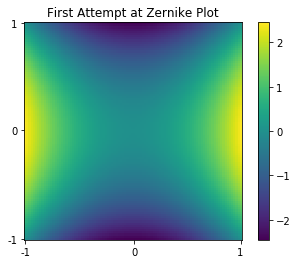

In [5]:
Z = np.zeros((100,100))
for i,x in enumerate(np.linspace(-1,1,100)):
    for j,y in enumerate(np.linspace(-1,1,100)):
        Z[j,i] = zern.evalCartesian(x,y)
        
plt.figure()
plt.title('First Attempt at Zernike Plot')
plt.imshow(Z, origin='lower')
plt.xticks([0,50,99],['-1','0','1'])
plt.yticks([0,50,99],['-1','0','1'])
plt.colorbar()

Wait ... this is a box! Aren't these polynomials supposed to be defined on the unit circle? Yes and, as we will see, they are only orthonormal over the unit circle. galsim.zernike.Zernike doesn't care, if we ask it to evaluate the polynomial at a location, it will evaluate the polynomial at that location. But we should create a mask so that only the relevant domain is defined. 

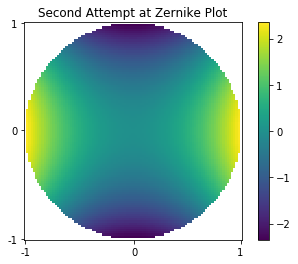

In [6]:
Z = np.zeros((100,100))
for i,x in enumerate(np.linspace(-1,1,100)):
    for j,y in enumerate(np.linspace(-1,1,100)):
        r = np.sqrt(x ** 2 + y ** 2)
        if abs(r) <= 1:
            Z[j,i] = zern.evalCartesian(x,y)
        else:
            Z[j,i] = np.nan
        
plt.figure()
plt.title('Second Attempt at Zernike Plot')
plt.imshow(Z, origin='lower')
plt.xticks([0,50,99],['-1','0','1'])
plt.yticks([0,50,99],['-1','0','1'])
plt.colorbar()

Woo! This looks exactly like $Z_2^{-2}$ from [wikipedia](https://en.wikipedia.org/wiki/Zernike_polynomials). However, we can make this a lot faster, and easier to read, if we use [vectorization](https://hackernoon.com/speeding-up-your-code-2-vectorizing-the-loops-with-numpy-e380e939bed3). Note that evalCartesian accepts list-like arguments, which is short for numpy.ndarrays. Here is the vectorized version of the code above.

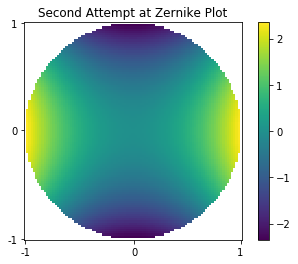

In [7]:
X,Y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
R = np.sqrt(X ** 2 + Y ** 2)
mask = np.abs(R) < 1
Z = zern.evalCartesian(X,Y) 
Z[~mask] = np.nan

plt.figure()
plt.title('Second Attempt at Zernike Plot')
plt.imshow(Z, origin='lower')
plt.xticks([0,50,99],['-1','0','1'])
plt.yticks([0,50,99],['-1','0','1'])
plt.colorbar()

There is one more piece to add. LSST has an annular aperture. Therefore we want to use the *annular* zernike polynomials. Perhaps you noticed that galsim.zernike.Zernike takes R_outer and R_inner as keyword arguments. For LSST the inner radius is 0.61, so we just need to change this and update the mask accordingly.

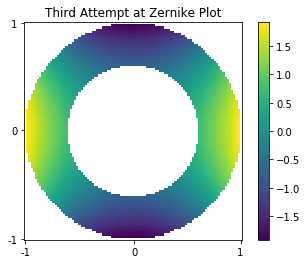

In [8]:
obscuration = 0.61
zern = galsim.zernike.Zernike(zernikes, R_inner=obscuration)

X,Y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
R = np.sqrt(X ** 2 + Y ** 2)
mask = np.logical_and(np.abs(R) < 1, np.abs(R) > obscuration)
Z = zern.evalCartesian(X,Y) 
Z[~mask] = np.nan

plt.figure()
plt.title('Third Attempt at Zernike Plot')
plt.imshow(Z, origin='lower')
plt.xticks([0,50,99],['-1','0','1'])
plt.yticks([0,50,99],['-1','0','1'])
plt.colorbar()

**Trick question:** Is this the same as just applying the mask to our previous Z's? Hint: No. You can plot both of them and compare. Can you think of why they are different? Hint: look at the title of the next section (Orthogonality). 

**Problem 1:** Can you plot zernikes 1-10 in separate subplots and label them with the names provided below. You can look at the [matplotlib documentation](https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/markevery_demo.html#sphx-glr-gallery-lines-bars-and-markers-markevery-demo-py) to learn how to plot multiple plots within a single figure. Note: Usually in CS things are indexed by 0 but in this case it looks like the first two zernikes are piston.

In [9]:
indexToName = {
    0: 'piston',
    1: 'piston',
    2: 'tilt',
    3: 'tip',
    4: 'defocus',
    5: 'oblique astigmatism',
    6: 'vertical astigmatism',
    7: 'vertical coma',
    8: 'horizontal coma',
    9: 'vertical trefoil',
    10: 'oblique trefoil',
}

# TODO: code here

### Orthogonality

A key property of this set of polynomials is that they are orthonormal, and the infinite set of them is complete. This means that we can decompose any continuous function into a set of zernike polynomials. Let's start by confirming that these polynomials are normalized - or that $\iint Z_i(x,y)Z_i(x,y) d\Omega = 1$, where $\Omega$ is the annulus. To do this numerically we just multiply them element-wise and sum them, then divide by the total number of pixels in the annulus. 

Integral =  0.993267951589


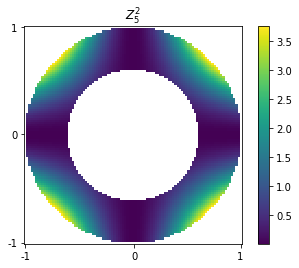

In [10]:
obscuration = 0.61
z5 = np.zeros(22)
z5[5] = 1
zern = galsim.zernike.Zernike(z5, R_inner=obscuration)
X,Y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
R = np.sqrt(X ** 2 + Y ** 2)
mask = np.logical_and(np.abs(R) < 1, np.abs(R) > obscuration)
Z = zern.evalCartesian(X,Y) 
Z[~mask] = np.nan

plt.figure()
plt.title(r'$Z_5^2$')
plt.imshow(Z*Z, origin='lower')
plt.xticks([0,50,99],['-1','0','1'])
plt.yticks([0,50,99],['-1','0','1'])
plt.colorbar()

integral = np.sum(Z[mask] * Z[mask]) / np.sum(mask)
print('Integral = ', integral)

**Problem 2:** Can you repeat the calculation above for a few other zernikes?

In [11]:
# TODO: code here

Now what happens if we change the resolution, do you think this will impact the numerical result? It is dificult to tell without trying it out.

Integral =  0.496505130179


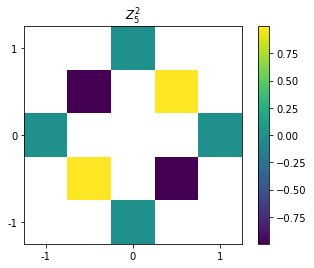

In [12]:
obscuration = 0.61
z5 = np.zeros(22)
z5[5] = 1
zern = galsim.zernike.Zernike(z5, R_inner=obscuration)

X,Y = np.meshgrid(np.linspace(-1,1,5), np.linspace(-1,1,5)) # Here is where we are changing the pixel resolution.
R = np.sqrt(X ** 2 + Y ** 2)
mask = np.logical_and(np.abs(R) <=1, np.abs(R) > obscuration)
Z = zern.evalCartesian(X,Y) 
Z[~mask] = np.nan

plt.figure()
plt.title(r'$Z_5^2$')
plt.imshow(Z, origin='lower')
plt.xticks([0,2,4],['-1','0','1'])
plt.yticks([0,2,4],['-1','0','1'])
plt.colorbar()

integral = np.sum(Z[mask] * Z[mask]) / np.sum(mask)
print('Integral = ', integral)

**Question:** Will this be a problem for LSST? Hint: LSST donuts will be 128 x 128 pixels.

If these polynomials are perfectly orthonormal then $\iint Z_i(x,y) Z_j(x,y)d\Omega = \delta_{ij}$. Hence a matrix matrix $M$ where $M_{ij} = \iint Z_i(x,y) Z_j(x,y)d\Omega$ should be equal to the identity matrix.

**Problem 3:** Can you fill in the code below to plot the matrix $M$ for $i,j <= 22$?

In [13]:
n = 22 
M = np.zeros((n, n))

X,Y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
R = np.sqrt(X ** 2 + Y ** 2)
mask = np.logical_and(np.abs(R) <=1, np.abs(R) > obscuration) 
# note that X,Y,R,mask are the same for the different polynomials, so we only need to create them once.

for i in range(n):
    for j in range(n):
        #TODO: code here to create Zi, Zj
        M[i,j] = np.sum(Zi[mask] * Zj[mask]) / np.sum(mask)
        
#TODO: code here to plot M. Hint: you will need plt.imshow().

NameError: name 'Zi' is not defined

### Decomposition

Our ultimate goal is to decompose functions like the wavefront, intensity, and surface maps into zernike polynomials. Let's start by creating a somewhat arbitrary annular surface $W$.

NameError: name 'arbitrary' is not defined

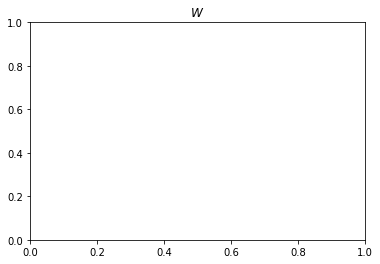

In [14]:
X,Y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
R = np.sqrt(X ** 2 + Y ** 2)
mask = np.logical_and(np.abs(R) <=1, np.abs(R) > obscuration) 
W = X**2-Y+1
W[~mask] = np.nan

plt.figure()
plt.title(r'$W$')
plt.imshow(arbitrary, origin='lower')
plt.xticks([0,50,99],['-1','0','1'])
plt.yticks([0,50,99],['-1','0','1'])
plt.colorbar()

We can take the inner product $W_i = \iint W(x,y) Z_i(x,y) d\Omega$ to see how much of $Z_i$ is in $W
$. Let's start with $Z_5$.

In [15]:
X,Y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
R = np.sqrt(X ** 2 + Y ** 2)
mask = np.logical_and(np.abs(R) <=1, np.abs(R) > obscuration) 

W = X**2-Y+1
W[~mask] = np.nan
z5 = np.zeros(22)
z5[5] = 1
zern = galsim.zernike.Zernike(z5, R_inner=obscuration)
Z5 = zern.evalCartesian(X,Y)

integral = np.sum(W[mask] * Z5[mask]) / np.sum(mask)
print("Z5 Inner Product = ", integral)

Z5 Inner Product =  -1.18768044495e-16


What about $Z_3$? 
**Problem 4:** Can you fill in the cell below.

In [16]:
X,Y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
R = np.sqrt(X ** 2 + Y ** 2)
mask = np.logical_and(np.abs(R) <=1, np.abs(R) > obscuration) 

W = X**2-Y+1
W[~mask] = np.nan
# TODO: code here to create Z3

integral = np.sum(W[mask] * Z3[mask]) / np.sum(mask)
print("Z3 Inner Product = ", integral)

NameError: name 'Z3' is not defined

**Problem 5:** Can you create a vector $\vec{W}$ such that $\vec{W}_i = \iint W(x,y) Z_i(x,y) d\Omega$?

In [17]:
# TODO: code here

**Problem 6:** Can you evaluate $\vec{W}$ and see how close it is to our original $W$? The cell below provides a hint on how to evaluate $\vec{W}$.

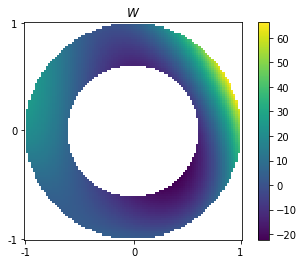

In [18]:
Wbar = np.random.poisson(5, size=10)
zern = galsim.zernike.Zernike(Wbar, R_inner=obscuration)
WbarEval = zern.evalCartesian(X,Y)
WbarEval[~mask] = np.nan

plt.figure()
plt.title(r'$W$')
plt.imshow(WbarEval, origin='lower')
plt.xticks([0,50,99],['-1','0','1'])
plt.yticks([0,50,99],['-1','0','1'])
plt.colorbar()

In [19]:
# TODO: code here

**Problem 7:** How does the error in the reconstruction change if we add poisson noise to W? Hint: see np.random.poisson.

In [20]:
# TODO: code here

**Challenge Problem:** What do the X,Y gradients of zernike polynomials look like? Are they orthonormal? Hint: see help(zern) above to see if there is already a method that does this.

In [ ]:
# TODO: code here